# VMR washout

In [2]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import get_cmap
from scipy import linalg
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture

In [3]:
# define path
projectpath = '/Users/anouk/dropbox/Gaze_VMR_adaptation/'

In [4]:
# set plot style
sns.set_style("ticks")
sns.despine()
# get paired colors for plots
cmap = get_cmap('Paired')  
clrs = cmap.colors
clrs_light = clrs[0::2]
clrs_dark = clrs[1::2]

<Figure size 432x288 with 0 Axes>

In [5]:
def plot_strategy_clusters(grouping_variable):
    
    # get number of groups
    k = len(strategy_rot1[grouping_variable].unique())
    
    # plot clusters, color by group, symbol by experiment
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.scatterplot(ax=ax, data=strategy_rot1, x='max_perc_1_10', y='max_perc_11_20', 
                hue=grouping_variable, palette=list(clrs_dark[:k]), style='exp', s=50);
    
    # label data points
    #for subj, x, y in zip(strategy_rot1['subj'], strategy_rot1['max_perc_1_10'], strategy_rot1['max_perc_11_20']):
    #    p.text(x+1, y, subj, verticalalignment='center')
    
    # axes
    ax.set_xlim([0, 102])
    ax.set_ylim([0, 102])
    ax.set_xlabel('Max % trials with reporting/gaze strategy - bins 1-10', fontsize=12)
    ax.set_ylabel('Max % trials with reporting/gaze strategy - bins 11-20', fontsize=12)

    # move the legend outside the figure
    ax.legend(bbox_to_anchor=(1,1));
    
    return ax

## Load data

In [6]:
# load data file
vmr = pd.read_csv(projectpath + 'table_VMRwashout_202101.csv')

# show top 5 rows
vmr.head()

,exp,day,block_name,bin_no,subj,hand_angle,report_angle,aimfix_angle,implicit_angle,implicit_angle_from_fix,perc_report_strategy,perc_fix_strategy
0,Exp1_reporting,1,baseline,1,AH1,-3.730713,NaN,NaN,NaN,NaN,NaN,25.000000
1,Exp1_reporting,1,baseline,2,AH1,-2.556249,NaN,NaN,NaN,NaN,NaN,12.500000
2,Exp1_reporting,1,baseline,3,AH1,-2.730130,NaN,NaN,NaN,NaN,NaN,25.000000
3,Exp1_reporting,1,baseline,4,AH1,-2.056363,NaN,NaN,NaN,NaN,NaN,33.333333
4,Exp1_reporting,1,baseline,5,AH1,-0.764877,NaN,NaN,NaN,NaN,NaN,33.333333


In [7]:
# get maximum number of bins per block to align data across experiments
n_bins_max = vmr.groupby(['block_name'], sort=False)['bin_no'].max()
n_bins_cum = np.cumsum(n_bins_max)
n_bins_max

# number of days in experiment
days = [1, 2]

# add cumulative bin number to vrm dataframe
vmr['bin_no_cum'] = ''
for s in vmr['subj'].unique():
    #grp = strategy_rot1[strategy_rot1['subj']==s].group.values[0]
    for d in days:
        base = (vmr['subj']==s) & (vmr['day']==d) & (vmr['block_name']=='baseline')
        vmr.loc[base,'bin_no_cum'] = vmr.loc[base,'bin_no']
        
        rot = (vmr['subj']==s) & (vmr['day']==d) & (vmr['block_name']=='rotation')
        vmr.loc[rot,'bin_no_cum'] = vmr.loc[rot,'bin_no'] + n_bins_cum['baseline']
        
        wo = (vmr['subj']==s) & (vmr['day']==d) & (vmr['block_name']=='washout')
        vmr.loc[wo,'bin_no_cum'] = vmr.loc[wo,'bin_no'] + n_bins_cum['rotation']
        
        nf = (vmr['subj']==s) & (vmr['day']==d) & (vmr['block_name']=='no feedback')
        vmr.loc[nf,'bin_no_cum'] = vmr.loc[nf,'bin_no'] + n_bins_cum['washout']
    
# show result
vmr.loc[rot,].head()

,exp,day,block_name,bin_no,subj,hand_angle,report_angle,aimfix_angle,implicit_angle,implicit_angle_from_fix,perc_report_strategy,perc_fix_strategy,bin_no_cum
6819,Exp7_WR,2,rotation,1,S16,-34.880410,-26.08,-31.135437,-8.800410,-3.744973,100.0,100.0,8
6820,Exp7_WR,2,rotation,2,S16,-40.110681,-28.08,-29.097873,-12.030681,-11.012809,100.0,100.0,9
6821,Exp7_WR,2,rotation,3,S16,-44.360407,-32.96,-30.259016,-11.400407,-14.101391,100.0,100.0,10
6822,Exp7_WR,2,rotation,4,S16,-44.480752,-26.92,-26.365874,-17.560752,-18.114878,100.0,100.0,11
6823,Exp7_WR,2,rotation,5,S16,-43.676209,-27.88,-27.140125,-15.796209,-16.536084,100.0,100.0,12


## Get percentage of trials with a strategy in the first rotation block
To look at how strategies are implemented over the course of the first rotation block, washout, and the second rotation block, we want to differentiate 'strategic' from 'non-strategic' participants. A strategy can show up in the verbally reported aiming angle and in the fixation angle prior to the reaching movement. Below, I compute:
1. the percentage of reporting trials with a verbally reported strategy
2. the percentage of non-reporting trials with a gaze fixation strategy

Because not all experiments and blocks have both measures, and not all participants express both types of strategy, I will use the maximum of these two percentages as our measure of 'strategicness' in this task. 

### Use all trials in the first rotation block

In [8]:
# all rotation 1 trials
perc_strategy_cols = ['perc_report_strategy','perc_fix_strategy']
strategy_rot1 = vmr[(vmr['day']==1) & (vmr['block_name']=='rotation')].groupby(['exp','subj'])[perc_strategy_cols].mean()
strategy_rot1['max_perc'] = strategy_rot1[perc_strategy_cols].max(axis=1)
strategy_rot1.reset_index(inplace=True)

# show result
strategy_rot1.head()

,exp,subj,perc_report_strategy,perc_fix_strategy,max_perc
0,Exp1_reporting,AH1,91.025641,76.708333,91.025641
1,Exp1_reporting,AK1,80.769231,56.666667,80.769231
2,Exp1_reporting,AM1,94.871795,27.208333,94.871795
3,Exp1_reporting,BL1,97.435897,80.750000,97.435897
4,Exp1_reporting,CH1,92.307692,10.541667,92.307692


### Use bins 1-10 and 11-20 in the first rotation block

In [9]:
# bins 1 to 10
perc_strategy_cols = ['perc_report_strategy','perc_fix_strategy']
strategy_rot1_1 = vmr[(vmr['day']==1) & (vmr['block_name']=='rotation') & 
                              (vmr['bin_no']<=10)].groupby(['exp','subj'])[perc_strategy_cols].mean()
strategy_rot1_1['max_perc'] = strategy_rot1_1[perc_strategy_cols].max(axis=1)
strategy_rot1_1.reset_index(inplace=True)

# show result
strategy_rot1_1.head()

,exp,subj,perc_report_strategy,perc_fix_strategy,max_perc
0,Exp1_reporting,AH1,72.222222,67.500000,72.222222
1,Exp1_reporting,AK1,22.222222,5.000000,22.222222
2,Exp1_reporting,AM1,77.777778,30.666667,77.777778
3,Exp1_reporting,BL1,88.888889,44.333333,88.888889
4,Exp1_reporting,CH1,66.666667,25.000000,66.666667


In [10]:
# bins 11 to 20
strategy_rot1_2 = vmr[(vmr['day']==1) & (vmr['block_name']=='rotation') & 
                              (vmr['bin_no']>10) & (vmr['bin_no']<=20)].groupby(['exp','subj'])[perc_strategy_cols].mean()
strategy_rot1_2['max_perc'] = strategy_rot1_2[perc_strategy_cols].max(axis=1)
strategy_rot1_2.reset_index(inplace=True)

# show result
strategy_rot1_2.head()

,exp,subj,perc_report_strategy,perc_fix_strategy,max_perc
0,Exp1_reporting,AH1,90.0,74.500000,90.0
1,Exp1_reporting,AK1,95.0,55.000000,95.0
2,Exp1_reporting,AM1,100.0,30.666667,100.0
3,Exp1_reporting,BL1,100.0,94.000000,100.0
4,Exp1_reporting,CH1,100.0,13.000000,100.0


### Merge percentages into a single dataframe

In [11]:
# merge 
strategy_rot1_bins = pd.merge(strategy_rot1_1, strategy_rot1_2, 
         on=['exp', 'subj'], suffixes=('_1_10', '_11_20'))
strategy_rot1 = pd.merge(strategy_rot1, strategy_rot1_bins, 
         on=['exp', 'subj'])

# show result
strategy_rot1.head()

,exp,subj,perc_report_strategy,perc_fix_strategy,max_perc,perc_report_strategy_1_10,perc_fix_strategy_1_10,max_perc_1_10,perc_report_strategy_11_20,perc_fix_strategy_11_20,max_perc_11_20
0,Exp1_reporting,AH1,91.025641,76.708333,91.025641,72.222222,67.500000,72.222222,90.0,74.500000,90.0
1,Exp1_reporting,AK1,80.769231,56.666667,80.769231,22.222222,5.000000,22.222222,95.0,55.000000,95.0
2,Exp1_reporting,AM1,94.871795,27.208333,94.871795,77.777778,30.666667,77.777778,100.0,30.666667,100.0
3,Exp1_reporting,BL1,97.435897,80.750000,97.435897,88.888889,44.333333,88.888889,100.0,94.000000,100.0
4,Exp1_reporting,CH1,92.307692,10.541667,92.307692,66.666667,25.000000,66.666667,100.0,13.000000,100.0


## K-means clustering of participants
Cluster participants into groups based on the maximum percentage of trials with a reporting or fixation strategy in the first rotation block. The K-means algorithm clusters data by trying to separate samples in groups of equal variance. A great overview of clustering methods is provided in the [Scikit-learn documentation on clustering](https://scikit-learn.org/stable/modules/clustering.html).

### All trials in rotation 1 (1-D) - two groups 
Let's start by dividing participants into two groups based on their 'strategicness' using all trials in the first rotation block.

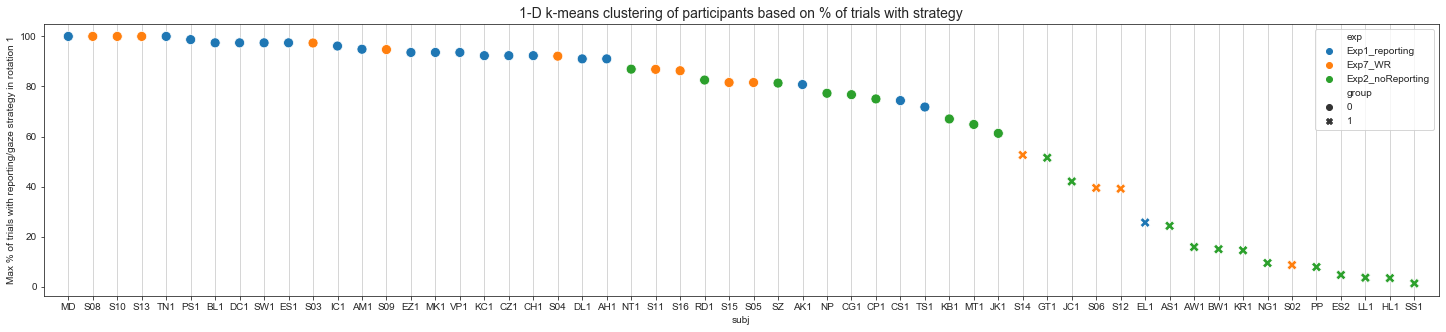

In [12]:
# get groups
k = 2
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
strategy_rot1['group'] = kmeans.fit_predict(strategy_rot1[['max_perc']])

# sort
strategy_rot1_sorted = strategy_rot1.sort_values(by=['max_perc'], ascending=False).reset_index(drop=True)

# plot groups - sorted, color by experiment, symbol by group
fig, ax = plt.subplots(figsize=(25,5))
sns.scatterplot(ax=ax, data=strategy_rot1_sorted, x='subj', y='max_perc', 
                hue='exp', style='group', s=100);
ax.set_xlim([-1, len(strategy_rot1.index)]);
ax.xaxis.grid(True)
ax.set_ylabel('Participant')
ax.set_ylabel('Max % of trials with reporting/gaze strategy in rotation 1')
ax.set_title('1-D k-means clustering of participants based on % of trials with strategy', 
             fontsize=14);

# save figure
#fig.savefig(projectpath + 'Clusters_kmeans1D%d.pdf' % k)

Participants in group 0 have a maximum percentage of trials with a strategy between 61 and 100%. Participants in group 1 have a maximum percentage of trials with a strategy between 1 and 52%. This could be a way to differentiate between 'strategic' and 'non-strategic' participants. However, some participants that are obviously strategic, as seen from the fast changes in hand angle in the first rotation block, end up in group 1 because they start implementing a strategy a bit later in the rotation block. 

### Bins 1-10 and 11-20 in rotation 1 (2-D)
To address this issue, I also computed the percentage of strategic trials separately for bins 1 to 10 (trials 1-80) and 11-20 (trials 81-160) in the first rotation block. Given these data and previous research from the lab, I expect three groups: a group that implements a strategy almost immediately after the start of the rotation, a group that starts implementing a strategy a bit later, and a group that doesn't implement a strategy. 

I will first take a data-driven approach to find the optimal number of clusters and see if this matches my expectation. 

#### Get optimal cluster size

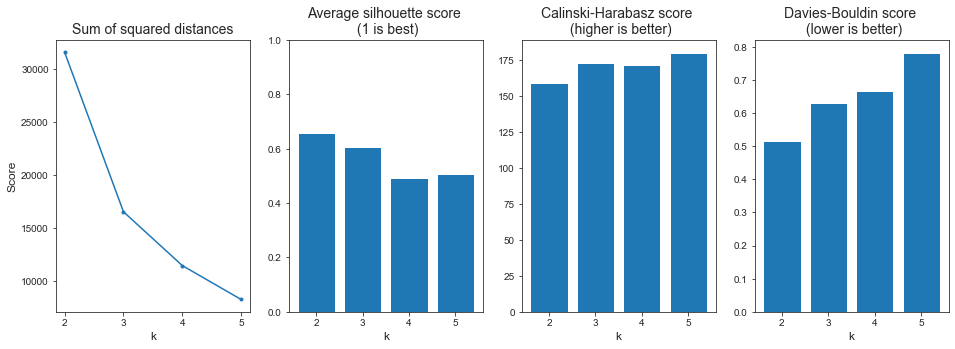

In [13]:
# compute scores for k = [2, 3, 4, 5]
K = range(2,6)
silhouette = []
ssdist = []
cal_har = []
dav_boul = []
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
    X = strategy_rot1[['max_perc_1_10','max_perc_11_20']];
    labels = kmeans.fit_predict(X) 
    silhouette.append(silhouette_score(X, labels))
    ssdist.append(kmeans.inertia_)
    cal_har.append(calinski_harabasz_score(X, labels))
    dav_boul.append(davies_bouldin_score(X, labels))

# plot scores
fig, ax = plt.subplots(1, 4, figsize=(16,5))
# plot sum of squared distances
ax[0].plot(K, ssdist, '.-')
ax[0].set_xticks(K)
ax[0].set_xlabel('k', fontsize=12)
ax[0].set_ylabel('Score', fontsize=12)
ax[0].set_title('Sum of squared distances', fontsize=14)
# plot silhouette scores
ax[1].bar(K, silhouette)
ax[1].set_xticks(K)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('k', fontsize=12)
ax[1].set_title('Average silhouette score \n (1 is best)', fontsize=14)
# plot Calinski-Harabasz scores
ax[2].bar(K, cal_har)
ax[2].set_xticks(K)
ax[2].set_xlabel('k', fontsize=12)
ax[2].set_title('Calinski-Harabasz score \n (higher is better)', fontsize=14)
# plot Calinski-Harabasz scores
ax[3].bar(K, dav_boul)
ax[3].set_xticks(K)
ax[3].set_xlabel('k', fontsize=12)
ax[3].set_title('Davies-Bouldin score \n (lower is better)', fontsize=14);

There is no clear optimal number of clusters here. The sum of squared distances plot doesn't show an elbow, silhouette score and Davies-Bouldin score slightly favour 2 clusters, while the Calinski-Harabasz score slightly favours 3 clusters. Based on our data and previous research from the lab, I will divide participants into 3 clusters. I will then examine whether these clusters map onto an early-strategic, late-strategic, and non-strategic group of participants.

#### Cluster participants into three groups

In [14]:
# set random seed to produce consistent results
np.random.seed(1) 

group
0    33
1    12
2    11
Name: subj, dtype: int64


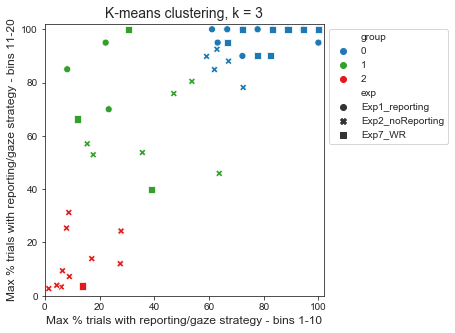

In [15]:
# get groups
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
strategy_rot1['group'] = kmeans.fit_predict(strategy_rot1[['max_perc_1_10','max_perc_11_20']])
print(strategy_rot1.groupby(['group'])['subj'].count())

# plot clusters
ax = plot_strategy_clusters('group')
ax.set_title('K-means clustering, k = %d' % k, fontsize=14);

# save the figure
#fig.savefig(projectpath + 'Clusters_kmeans%d.pdf' % k)

In [16]:
# sort and show groups
strategy_rot1_sorted = strategy_rot1.sort_values(by=['group','max_perc_11_20','max_perc_1_10']).reset_index(drop=True)
strategy_rot1_sorted.drop(columns=['perc_report_strategy_1_10','perc_fix_strategy_1_10',
                                   'perc_report_strategy_11_20','perc_fix_strategy_11_20'])

,exp,subj,perc_report_strategy,perc_fix_strategy,max_perc,max_perc_1_10,max_perc_11_20,group
0,Exp2_noReporting,CG1,NaN,76.726190,76.726190,72.500000,78.154762,0
1,Exp2_noReporting,RD1,NaN,82.568452,82.568452,62.000000,84.880952,0
2,Exp2_noReporting,NT1,NaN,86.919643,86.919643,67.142857,88.035714,0
3,Exp2_noReporting,SZ,NaN,81.354167,81.354167,59.107143,89.821429,0
4,Exp1_reporting,AH1,91.025641,76.708333,91.025641,72.222222,90.000000,0
5,Exp7_WR,S15,81.578947,80.833333,81.578947,77.777778,90.000000,0
6,Exp7_WR,S16,0.000000,86.291667,86.291667,82.583333,90.000000,0
7,Exp2_noReporting,MT1,NaN,64.836310,64.836310,62.916667,92.500000,0
8,Exp1_reporting,CS1,74.358974,46.375000,74.358974,63.166667,95.000000,0
9,Exp7_WR,S05,81.578947,18.958333,81.578947,66.666667,95.000000,0


Looking at the individual participant data (not shown here), these clusters agree well with the idea of a non-strategic (group 2, red data points), late-strategic (group 0, blue datapoints) and early-strategic group (group 1, green data points).

## GMM clustering of participants 
K-means clustering assumes that the clusters are isotropic, which is not necessarily the case for our data. Gaussian mixture models, used for clustering, can deal with different covariance structures in the data. A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

#### Get optimal model

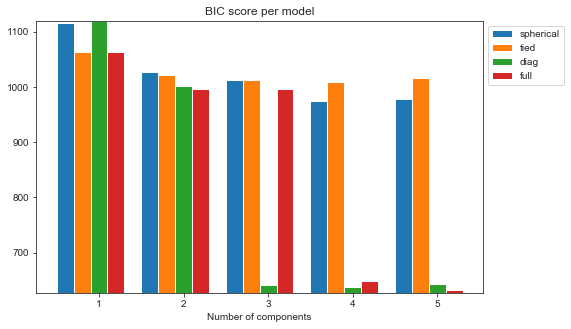

In [17]:
# calculate fits for k = [1, 2, 3, 4, 5] and different covariance structures
K = range(1,6)
cv_types = ['spherical', 'tied', 'diag', 'full']
X = strategy_rot1[['max_perc_1_10','max_perc_11_20']]
bic = []
for cv_type in cv_types:
    for k in K:
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type, n_init=10)
        gmm.fit(X)
        bic.append(gmm.bic(X))

bic = np.array(bic)

# plot the BIC scores for each model
bars = []
fig, ax = plt.subplots(figsize=(8, 5))
for i, cv_type in enumerate(cv_types):
    xpos = np.array(K) + .2 * (i - 2)
    bars.append(ax.bar(xpos, bic[i * len(K): (i + 1) * len(K)], width=.2))
ax.set_xticks(K)
ax.set_xlabel('Number of components')
ax.set_ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
ax.set_title('BIC score per model')
ax.legend([b[0] for b in bars], cv_types, bbox_to_anchor=(1,1));

This graphs suggests that the best models are:
* 3 components with a diagonal covariance structure
* 4 components with a diagonal or full covariance structure
* 5 components with a full or diagonal covariance structure

#### Fit model with 3 components

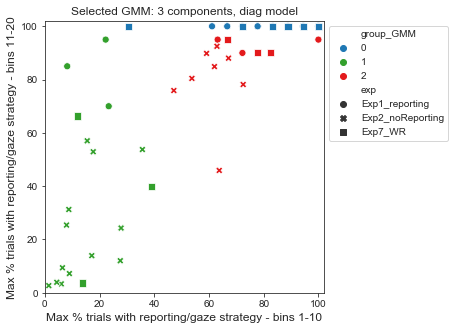

In [18]:
# fit the model
k = 3
gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=10)
gmm.fit(X)
strategy_rot1['group_GMM'] = gmm.predict(X)

# plot clusters
ax = plot_strategy_clusters('group_GMM')
ax.set_title('Selected GMM: %d components, %s model' % (gmm.n_components, gmm.covariance_type));
                                          
# save figure
#plt.savefig(projectpath + 'Clusters_GGM%d.pdf' % k)

GMM clustering results in an odd grouping, where all participants with 100% strategic trials in bins 11-20 make up one group. Let's use k-means to group participants. 

## Save k-means clusters

In [19]:
# discard column with GMM clusters
strategy_rot1.drop(columns='group_GMM')

# re-number groups so that 0 = 'no strategy', 1 = 'late strategy', 2 = 'early strategy'
strategy_rot1['group'].replace({0: 2, 2: 0}, inplace=True)
print(strategy_rot1.groupby(['group'])['subj'].count())

# fill in k-means group values in vmr dataframe
vmr['group'] = 99
for s in strategy_rot1['subj']:
    grp = strategy_rot1[strategy_rot1['subj']==s].group.values[0]
    vmr['group'].mask(vmr['subj']==s, grp, inplace=True)

# group name
#vmr['group_name'] = 'no strategy'
#vmr['group_name'].mask(vmr['group']==1, 'late strategy', inplace=True) # late strategy
#vmr['group_name'].mask(vmr['group']==2, 'early strategy', inplace=True) # early strategy
    
# show result
vmr.head()

group
0    11
1    12
2    33
Name: subj, dtype: int64


,exp,day,block_name,bin_no,subj,hand_angle,report_angle,aimfix_angle,implicit_angle,implicit_angle_from_fix,perc_report_strategy,perc_fix_strategy,bin_no_cum,group
0,Exp1_reporting,1,baseline,1,AH1,-3.730713,NaN,NaN,NaN,NaN,NaN,25.000000,1,2
1,Exp1_reporting,1,baseline,2,AH1,-2.556249,NaN,NaN,NaN,NaN,NaN,12.500000,2,2
2,Exp1_reporting,1,baseline,3,AH1,-2.730130,NaN,NaN,NaN,NaN,NaN,25.000000,3,2
3,Exp1_reporting,1,baseline,4,AH1,-2.056363,NaN,NaN,NaN,NaN,NaN,33.333333,4,2
4,Exp1_reporting,1,baseline,5,AH1,-0.764877,NaN,NaN,NaN,NaN,NaN,33.333333,5,2


In [20]:
%store strategy_rot1
%store vmr 

Stored 'strategy_rot1' (DataFrame)
Stored 'vmr' (DataFrame)
